In [1]:
%%bash
pip install pytorch-lightning

  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=7511f4e19e53add46ad7cfaa7dd134eac3fbe01770644858e48f557aac530d2b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=924c1974c5544e19609cef0137907211d11627a4e15b0c8c31c5e48dd77c1522
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
%%bash
pip install "ray[tune]"

In [4]:
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision
import pytorch_lightning as pl
import os
from ray.tune.integration.pytorch_lightning import TuneReportCallback

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_dir  = 'drive/MyDrive/data' 

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])



train_dataset = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_dataset = datasets.ImageFolder(data_dir + '/test', transform=transform)
validation_dataset = datasets.ImageFolder(data_dir + '/valid', transform=transform)

classes = ['melanoma', 'seborrheic_keratosis', 'nevus']
train_dataset.class_to_idx

{'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2}

In [8]:
number_to_label = {
    0: 'melanoma',
    1: 'nevus',
    2: 'seborrheic_keratosis'}

('nevus', tensor(1))

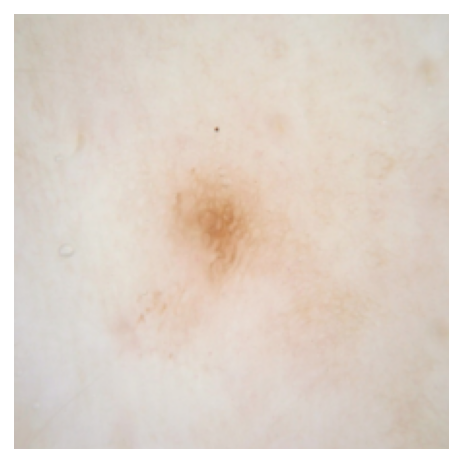

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

images, labels = next(iter(train_loader))
label = number_to_label[labels[0].item()]
imshow(images[0], normalize=False)
label, labels[0]


('nevus', tensor(1))

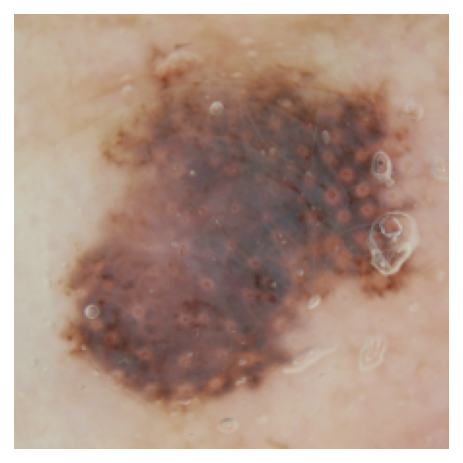

In [10]:
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64)

images, labels = next(iter(train_loader))
label = number_to_label[labels[0].item()]
imshow(images[0], normalize=False)
label, labels[0]


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
import torchvision.models as models
from torch import nn
from torch.nn import functional as F

class ImagenetTransferLearning(pl.LightningModule):
    def __init__(self, learning_rate):
        # init a pretrained resnet
        super().__init__()
        num_target_classes = 3
        self.learning_rate = learning_rate
        self.feature_extractor = models.wide_resnet101_2(pretrained=True)
        self.feature_extractor.eval()

        # use the pretrained model to classify cifar-10 (10 image classes)
        self.classifier = nn.Linear(1000, num_target_classes)
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()

    def forward(self, x):
        representations = self.feature_extractor(x)
        x = self.classifier(representations)
        return x.cuda()

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = net(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.train_acc(y_hat, y)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=False)
        return loss

    def test_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = net(x)
        loss = F.cross_entropy(y_hat, y)
   
        return loss
      
    def validation_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        x, y = x.cuda(), y.cuda()
        y_hat = net(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('valid_loss', loss)
        self.valid_acc(y_hat, y)
        self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def train_dataloader(self):
      return train_loader

    def val_dataloader(self):
      return validation_loader

    def test_dataloader(self):
      return test

In [21]:
net = ImagenetTransferLearning(0.01)
net.to(device)

ImagenetTransferLearning(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (do

In [22]:
trainer = pl.Trainer(max_epochs=13,gpus=1, progress_bar_refresh_rate=20, auto_lr_find=True)
trainer.tune(net)
net.learning_rate

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type     | Params
-----------------------------------------------
0 | feature_extractor | ResNet   | 126 M 
1 | classifier        | Linear   | 3.0 K 
2 | train_acc         | Accuracy | 0     
3 | valid_acc         | Accuracy | 0     
-----------------------------------------------
126 M     Trainable params
0         Non-trainable params
126 M     Total params


LR finder stopped early due to diverging loss.
Learning rate set to 0.01


0.01

In [32]:
lr_finder.plot()

NameError: ignored

In [23]:
trainer.fit(net)

  
print('Finished Training')


  | Name              | Type     | Params
-----------------------------------------------
0 | feature_extractor | ResNet   | 126 M 
1 | classifier        | Linear   | 3.0 K 
2 | train_acc         | Accuracy | 0     
3 | valid_acc         | Accuracy | 0     
-----------------------------------------------
126 M     Trainable params
0         Non-trainable params
126 M     Total params


Finished Training


('seborrheic_keratosis', tensor(2))

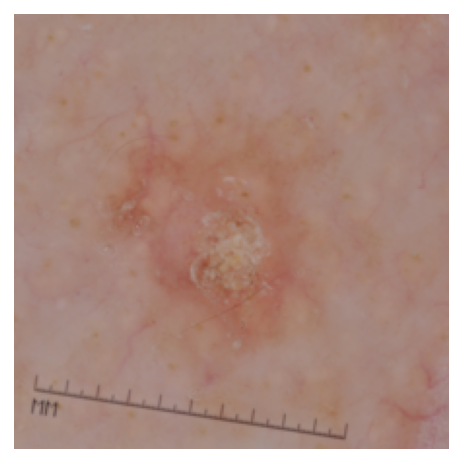

In [24]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

images, labels = next(iter(train_loader))
label = number_to_label[labels[0].item()]
imshow(images[0], normalize=False)
label, labels[0]

In [26]:
trainer.test()


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'valid_acc': tensor(0.5933, device='cuda:0'),
 'valid_acc_epoch': tensor(0.5933, device='cuda:0'),
 'valid_loss': tensor(2.7666, device='cuda:0')}
--------------------------------------------------------------------------------


[{'valid_acc': 0.5933333039283752,
  'valid_acc_epoch': 0.5933333039283752,
  'valid_loss': 2.7665648460388184}]

In [27]:
trainer.test(test_dataloaders=test_loader)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'valid_acc': tensor(0.5933, device='cuda:0'),
 'valid_acc_epoch': tensor(0.5933, device='cuda:0'),
 'valid_loss': tensor(2.7666, device='cuda:0')}
--------------------------------------------------------------------------------


[{'valid_acc': 0.5933333039283752,
  'valid_acc_epoch': 0.5933333039283752,
  'valid_loss': 2.7665648460388184}]

Epoch 1, Batch 20 loss: 0.9134159296751022
Epoch 1, Batch 40 loss: 0.7983715564012528
Epoch 1, Batch 60 loss: 0.6938753128051758
Epoch 2, Batch 20 loss: 0.6863763302564621
Epoch 2, Batch 40 loss: 0.7220188871026039

# Нова секция

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(0), labels.cuda(0)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [31]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(0), labels.cuda(0)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of melanoma :  0 %
Accuracy of seborrheic_keratosis : 83 %
Accuracy of nevus :  0 %
